In [1]:
import meow as mw
import jax.numpy as np
import matplotlib.pyplot as plt

## Preparation
let's perform a mode simulation

In [2]:
length = 10.0
box = mw.Box(
    x_min=-0.22,
    x_max=0.22,
    y_min=0,
    y_max=0.22,
    z_min=0.0,
    z_max=length,
)

In [3]:
struct = mw.Structure(material=mw.silicon, geometry=box)

In [4]:
env = mw.Environment(wl=1.55, T=25.0)

In [5]:
cells = mw.create_cells(
    structures=[struct],
    mesh=mw.Mesh2d(
        x = np.linspace(-1, 1, 101),
        y = np.linspace(-1, 1, 101),
    ),
    Ls = [length/3]*3
)
css = [mw.CrossSection(cell=cell, env=env) for cell in cells]

In [6]:
modes = [mw.compute_modes(cs, num_modes=2) for cs in css]

In [63]:
modes_ = modes.copy()

In [153]:
modes = modes_.copy()

In [175]:
modes[1] = [m*complex(np.exp(1j)) for m in modes[1]]

In [176]:
from meow.eme import compute_interface_s_matrices, compute_propagation_s_matrices
from meow.eme import compute_interface_s_matrix
from meow.eme.sax import _get_netlist
import sax
from sax.backends import circuit_backends
evaluate_circuit = circuit_backends["klu"]

In [177]:
propagations = compute_propagation_s_matrices(modes)
interfaces = compute_interface_s_matrices(
    modes, enforce_reciprocity=False,
)

unities = [compute_interface_s_matrix(mode, mode, enforce_reciprocity=False) for mode in modes]


## TODO get rid of unities to increase efficiency

In [178]:
def _connect_two(l, r):
    """l -> left, r -> right"""
    #TODO there must be an easier way to do this...
    s_l, p_l = sax.sdense(l)
    s_r, p_r = sax.sdense(r)
    instances = {"l": l, "r": r}
    p_lr = [p for p in p_l.keys() if "right" in p] #right ports of left
    p_rl = [p for p in p_r.keys() if "left" in p] #left ports of right

    p_ll = [p for p in p_l.keys() if "left" in p] #left ports of left
    p_rr = [p for p in p_r.keys() if "right" in p] #right ports of right

    p_lr.sort()
    p_rl.sort()
    connections = {f"l,{pl}": f"r,{pr}" for pl,pr in zip(p_lr, p_rl)}
    ports = {
        **{p: f"l,{p}" for p in p_ll},
        **{p: f"r,{p}" for p in p_rr}
    }
    net = dict(
        instances = instances,
        connections = connections,
        ports = ports
    )
    return evaluate_circuit(**net)

In [179]:
def pi_pairs(propagations, interfaces, unities):
    """generates the S-matrices of cells: a combination of propagation and interface matrix"""
    S = []
    for i in range(len(propagations)):
        p = propagations[f"p_{i}"]
        if i == len(interfaces):
            S.append(p)
        else:
            c = interfaces[f"i_{i}_{i+1}"]
            S.append(_connect_two(p, c))
    
    return S

In [180]:
pairs = pi_pairs(propagations, interfaces, unities)

In [181]:
def l2r_matrices(pairs):
    Ss=[pairs[0]]

    for p in pairs[1:]:
        Ss.append(_connect_two(Ss[-1], p))
    
    return Ss
    
l2rs = l2r_matrices(pairs)

In [182]:
def r2l_matrices(pairs):
    Ss=[pairs[-1]]

    for p in pairs[-1::-1]:
        Ss.append(_connect_two(p, Ss[-1]))
    
    return Ss[::-1]

r2ls = r2l_matrices(pairs)

let's assume excitation only from the left

In [183]:
excitation_l = np.zeros(len(modes[0]))
#excitation_l = excitation_l.at[1].set(1)
excitation_r = np.zeros(len(modes[-1]))
excitation_r = excitation_l.at[1].set(1)

amplitudes = []

In [184]:
l2rs[0]

(Array([[ 7.14722339e-22+4.91917334e-22j,  9.04760529e-11-3.31202218e-11j,
          2.66144286e-01+9.63933202e-01j, -2.39664491e-12-8.68031401e-12j],
        [-1.04426285e-10+3.82269309e-11j, -5.79525162e-17+5.22647081e-17j,
          8.46643947e-12+3.06828624e-12j,  9.40166001e-01+3.40716732e-01j],
        [ 7.65746878e-01-6.43142067e-01j,  7.33328049e-13+8.97523281e-12j,
          8.67636872e-22+3.93156399e-27j,  9.63476265e-11-1.37404749e-19j],
        [ 6.89580775e-12-5.79177327e-12j, -8.14342597e-02-9.96678715e-01j,
         -1.11203181e-10-8.76536237e-19j,  6.56693095e-17+4.21651358e-17j]],      dtype=complex128),
 {'left@0': 0, 'left@1': 1, 'right@0': 2, 'right@1': 3})

In [185]:
def split_square_matrix(matrix, idx):
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("Matrix has to be square")
    return [matrix[:idx,:idx], matrix[:idx,idx:]], [matrix[idx:,:idx], matrix[idx:,idx:]]

    # Attention! I am not sure the indexing is correct here!! Testing needed

In [186]:
forwards=[]
backwards=[]
for l2r, r2l in zip(l2rs, r2ls):
    s_l2r = l2r[0]
    s_r2l = r2l[0]

    m = len([k for k in l2r[1].keys() if "right" in k])
    n = s_l2r.shape[0] - m
    l = s_r2l.shape[0] - m
    [u11, u21],[u12, u22] = split_square_matrix(s_l2r, n)
    [v11, v21],[v12, v22] = split_square_matrix(s_r2l, m)

    RHS = u21@excitation_l + u22@v12@excitation_r
    LHS = np.diag(np.ones(m)) - u22@v11
    forward = np.linalg.solve(LHS, RHS)
    backward = v21@excitation_r + v11@forward # Attention v21 was v12

    forwards.append(forward)
    backwards.append(backward)



In [187]:
forwards


[Array([-8.30167175e-11-4.88987703e-11j, -3.51815631e-17-6.96602308e-17j],      dtype=complex128),
 Array([ 8.05374928e-11-1.71795659e-10j, -8.16344206e-17-4.80876607e-17j],      dtype=complex128),
 Array([-4.88176816e-11-1.83349039e-10j, -4.12813699e-17+8.52807890e-17j],      dtype=complex128)]

In [188]:
backwards

[Array([-6.11452454e-12+1.47866401e-11j, -8.61637390e-01-5.07524391e-01j],      dtype=complex128),
 Array([ 3.77394178e-12+8.17618111e-12j, -9.83004231e-01-1.83582901e-01j],      dtype=complex128),
 Array([0.        +0.j        , 0.26302339-0.96478946j], dtype=complex128)]

In [189]:
z = np.linspace(0, length, 200)

Exemplarily getting the ex component

Text(0, 0.5, 'x in um')

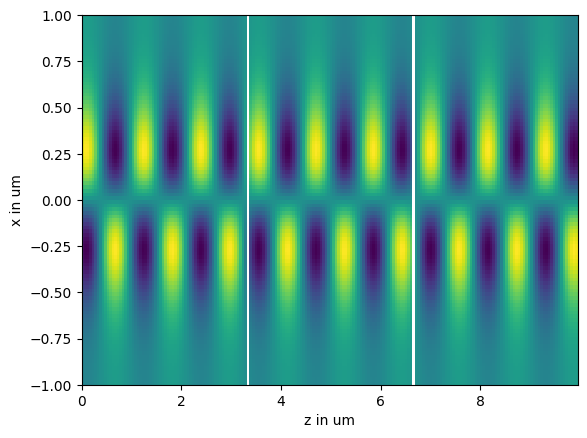

In [190]:
l = 0
y = 0.5

mode_set = modes[0]
mesh_y = mode_set[0].cell.mesh.y
mesh_x = mode_set[0].cell.mesh.x
i_y = np.argmin(np.abs(mesh_y-y))

for mode_set, forward, backward in zip(modes, forwards, backwards):
    Ex = 0
    cell = mode_set[0].cell
    z_ = z[np.logical_and(z>=cell.z_min, z<cell.z_max)]
    z_local = z_[:-1] + np.diff(z_)/2 - cell.z_min
    for mode, f, b in zip(mode_set, forward, backward):
        E_slice = mode.Ex[:,i_y]
        #plt.plot(E_slice)
        Ex += np.outer(f*E_slice.T, np.exp(
            2j * np.pi * mode.neff / mode.env.wl * z_local
        ))

        Ex += np.outer(b*E_slice.T, np.exp(
            -2j * np.pi * mode.neff / mode.env.wl * z_local
        ))
        
    X,Y = np.meshgrid(z_, mesh_x)
    plt.pcolormesh(X,Y,Ex.real)
plt.xlabel("z in um")
plt.ylabel("x in um")